# DETR (DEtection TRansformers)

Blablabla justify

## Load the model

We'll replicate the same steps as for the above models. First load the pre-trained model.

In [12]:
from transformers import AutoImageProcessor
from transformers import DetrForObjectDetection

base_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
base_image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Test the pre-trained model

Use the same sample image as for the previous models to test the pre-trained model.

In [19]:
import torch
from PIL import ImageDraw

def make_prediction(model, image_processor, image, confidence_threshold=0.7):
    # Preprocess the image
    inputs = image_processor(images=image, return_tensors="pt")

    # Perform inference
    outputs = model(**inputs)

    # Process the results and display the image with the detected objects
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=confidence_threshold, target_sizes=target_sizes)[0]
    image_with_boxes = image.copy()
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        # (xmin, ymin, xmax, ymax)
        box = [round(i, 2) for i in box.tolist()]
        # Add boxes to the image
        image_draw = ImageDraw.Draw(image_with_boxes)
        image_draw.rectangle(((box[0], box[1]),(box[2], box[3])), outline="red", width=3)
        # Add labels to the image
        image_draw.text((box[0], box[1]), f"{model.config.id2label[label.item()]} {round(score.item(), 3)}", fill="red", align="center")
    return image_with_boxes

/var/folders/kd/sn90g5rn3j78k5hhy6jqx_pm0000gn/T/ipykernel_21744/1846484438.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display


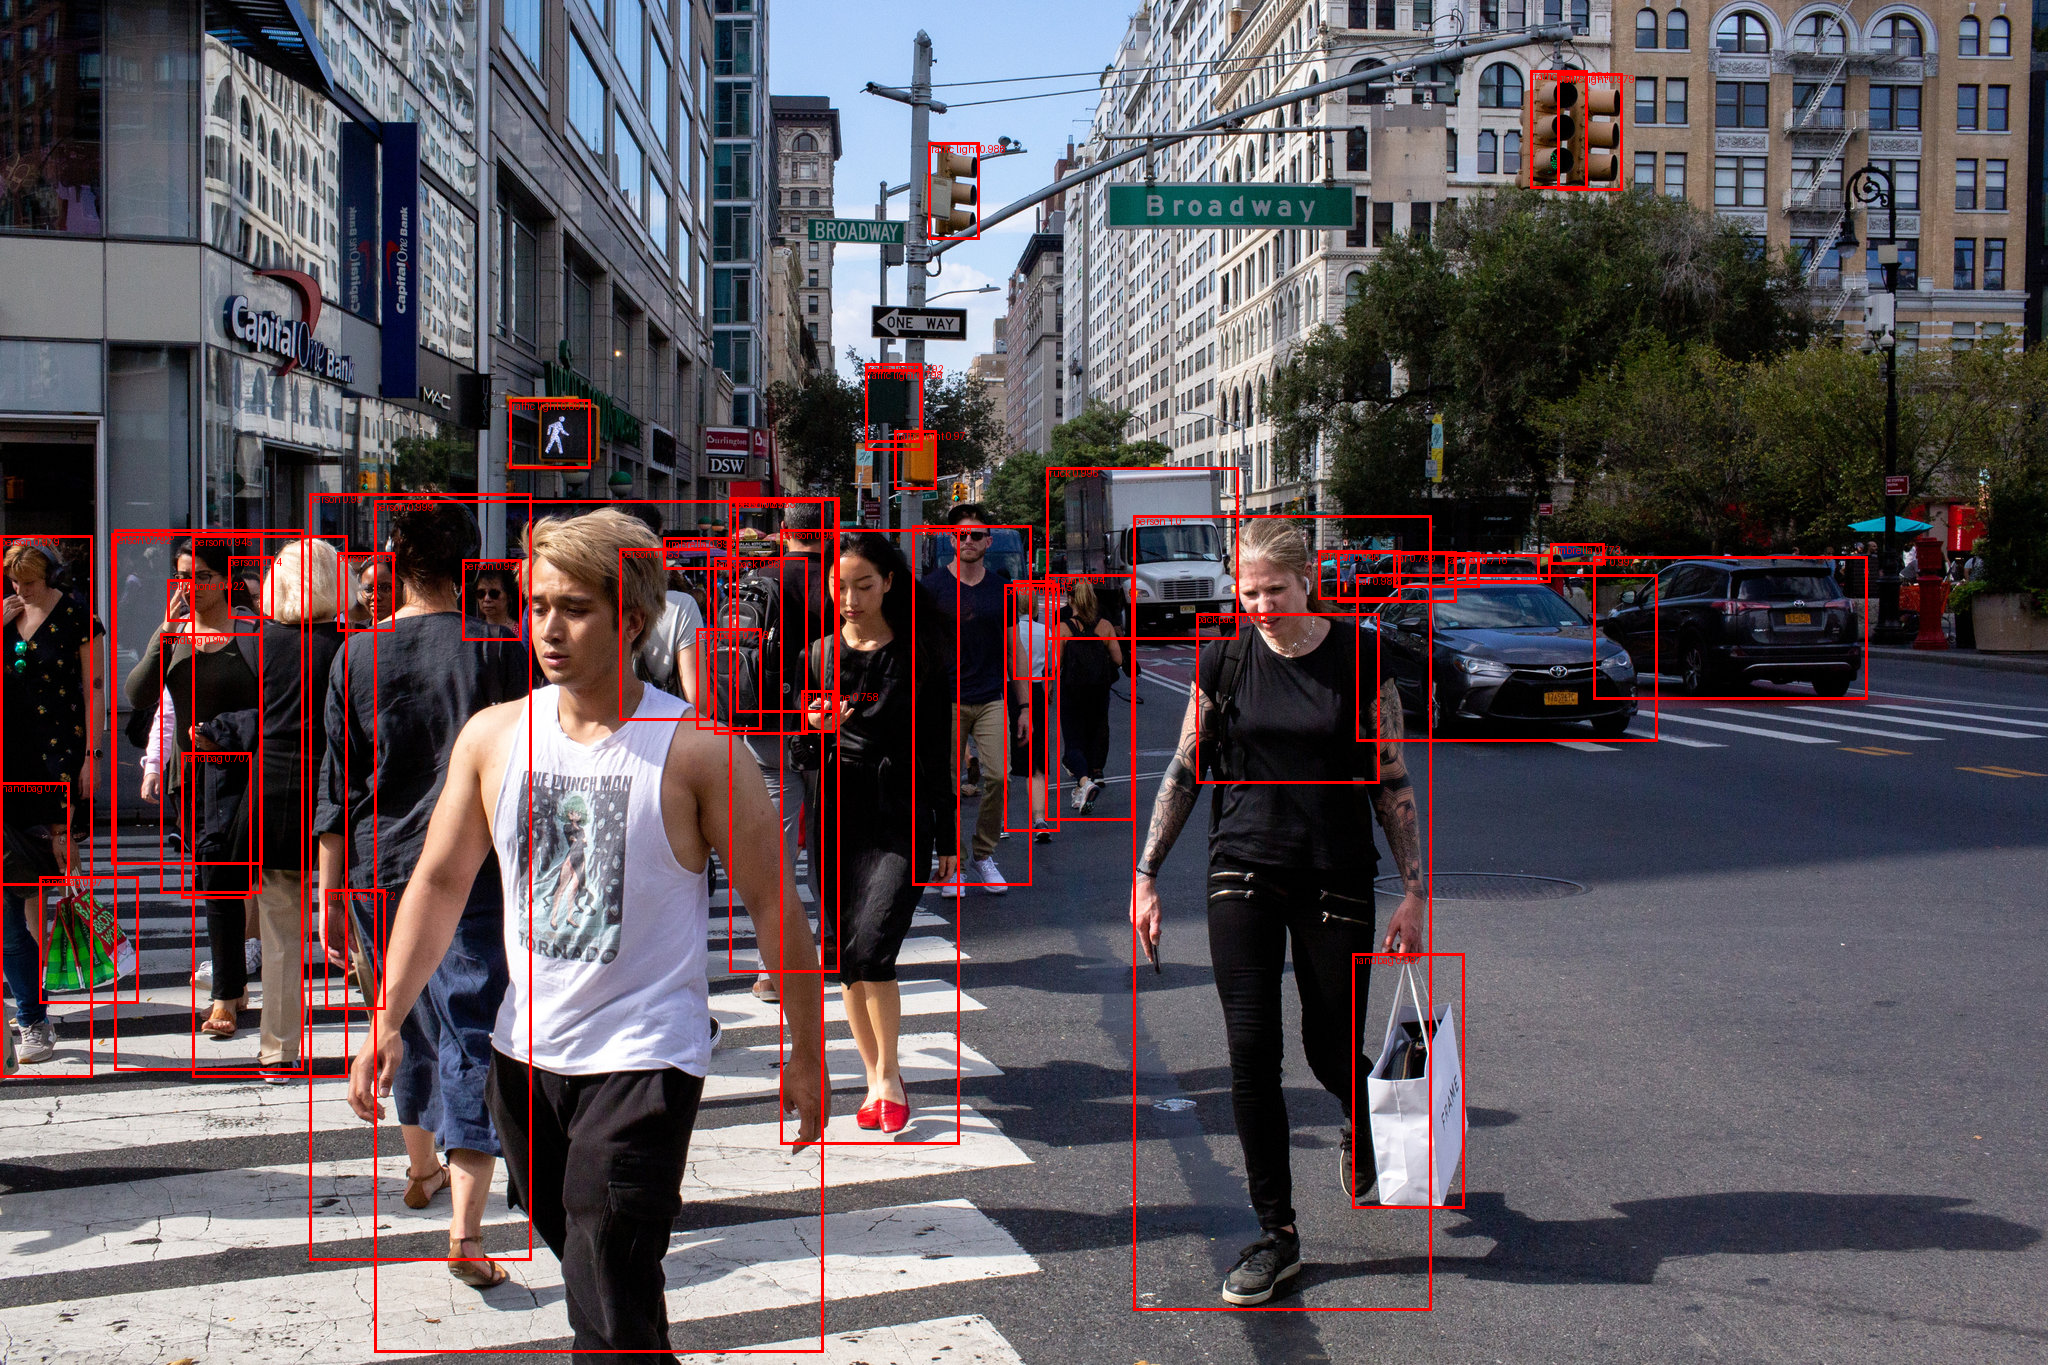

In [20]:
from PIL import Image
from IPython.core.display import display

image = Image.open("data_source/SampleDataset/street-sample1.png")

image_with_boxes = make_prediction(base_model, base_image_processor, image)

# Display the image with boxes
display(image_with_boxes)

## Test base model on dataset

Now attempt to make a prediction using one of our brain tumor images, see if it can detect anything; it shouldn't be able to.

/var/folders/kd/sn90g5rn3j78k5hhy6jqx_pm0000gn/T/ipykernel_21744/3442928634.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display


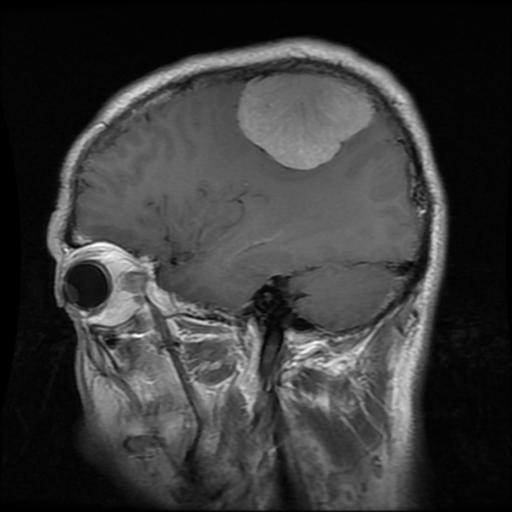

In [21]:
from PIL import Image
from IPython.core.display import display

image = Image.open("./datasets/raw/raw/meningioma/Tr-me_0547.jpg")

image_with_boxes = make_prediction(base_model, base_image_processor, image)

# Display the image with boxes
display(image_with_boxes)

## Fine-tuning the model

And with that, we can now start fine-tuning the model on our datasets.
All the training here below was performed on Google Colab, because the local computer was not powerful enough to handle the training, so you won't see any output here.

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import DetrImageProcessor, DetrForObjectDetection

import os
import pytorch_lightning as pl

class HuggingFaceSaveCallback(pl.Callback):
    def __init__(self, save_dir, save_frequency=5):
        """
        :param save_dir: Base directory to the model files.
        :param save_frequency: Save the model every 'save_frequency' epochs.
        """
        super().__init__()
        self.save_dir = save_dir
        self.save_frequency = save_frequency

    def on_train_epoch_end(self, trainer, pl_module):
        """Called when the epoch ends."""
        epoch = trainer.current_epoch
        # epoch is 0-based, so we use (epoch+1)
        if (epoch + 1) % self.save_frequency == 0:
            save_path = os.path.join(self.save_dir, f"detr-{epoch+1}")
            os.makedirs(save_path, exist_ok=True)
            pl_module.model.save_pretrained(save_path)
            pl_module.model.config.save_pretrained(save_path)
            if hasattr(pl_module, "processor"):
                pl_module.processor.save_pretrained(save_path)
            print(f"Saved model at epoch {epoch+1} to: {save_path}")


# =============================================================================
# 1. Define a Dataset that converts YOLO-format to COCO-format on the fly
# =============================================================================
class BrainTumorCocoDataset(Dataset):
    """
    Expects a directory structure like:

        dataset_dir/
            training/
                images/       <-- e.g. image1.jpg, image2.jpg, ...
                labels/       <-- e.g. image1.txt, image2.txt, ...
            testing/
                images/
                labels/

    Each label file is in YOLO format:
        <class> <x_center> <y_center> <width> <height>
    with coordinates normalized to [0,1].

    This dataset converts each annotation into COCO format (absolute pixel coordinates)
    as required by the DETR image processor.
    """
    def __init__(self, dataset_dir, split="training", processor=None):
        self.dataset_dir = dataset_dir
        self.split = split
        self.images_dir = os.path.join(dataset_dir, split, "images")
        self.labels_dir = os.path.join(dataset_dir, split, "labels")
        self.image_files = sorted([
            f for f in os.listdir(self.images_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ])
        if processor is None:
            raise ValueError("A DETR image processor must be provided!")
        self.processor = processor

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_filename)
        image = Image.open(image_path).convert("RGB")
        width, height = image.size

        # Load YOLO annotations (if any) and convert them to COCO-style annotations
        label_filename = os.path.splitext(image_filename)[0] + ".txt"
        label_path = os.path.join(self.labels_dir, label_filename)
        annotations = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for ann_id, line in enumerate(f):
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue  # Skip malformed lines
                    # YOLO: class, x_center, y_center, width, height (all normalized)
                    cls = int(parts[0])
                    x_center, y_center, w_norm, h_norm = map(float, parts[1:])
                    # Convert from center-based normalized coordinates to absolute COCO bbox:
                    x_min = (x_center - w_norm / 2) * width
                    y_min = (y_center - h_norm / 2) * height
                    w_abs = w_norm * width
                    h_abs = h_norm * height
                    area = w_abs * h_abs
                    annotation = {
                        "bbox": [x_min, y_min, w_abs, h_abs],
                        "category_id": cls,
                        "area": area,
                        "iscrowd": 0,
                    }
                    annotations.append(annotation)
        # Create a target dict in COCO format
        target = {
            "image_id": idx,
            "annotations": annotations
        }

        # Preprocess both the image and annotations using the DETR processor.
        # This resizes the image, normalizes it, and converts the annotations appropriately.
        encoding = self.processor(images=image, annotations=target, return_tensors="pt")
        # Remove the batch dimension for the image and labels
        pixel_values = encoding["pixel_values"].squeeze(0)
        processed_target = encoding["labels"][0]
        return pixel_values, processed_target

# =============================================================================
# 2. Create the DETR image processor and DataLoader collate_fn
# =============================================================================
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

def collate_fn(batch):
    """
    Batches a list of (pixel_values, target) tuples. Uses the processor to pad images
    to the same size and creates a pixel mask.
    """
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {
        "pixel_values": encoding["pixel_values"],
        "pixel_mask": encoding["pixel_mask"],
        "labels": labels,
    }
    return batch

# =============================================================================
# 3. Create training (and optionally validation) DataLoaders
# =============================================================================
dataset_dir = "processed_split"
# dataset_dir = "processed_augmented" # uncomment and comment above for augmented dataset

train_dataset = BrainTumorCocoDataset(dataset_dir, split="training", processor=processor)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=11, collate_fn=collate_fn)

val_dataset = BrainTumorCocoDataset(dataset_dir, split="testing", processor=processor)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=11, collate_fn=collate_fn)


# =============================================================================
# 5. Define a PyTorch Lightning Module for fine-tuning DETR
# =============================================================================
import pytorch_lightning as pl

class DetrLightning(pl.LightningModule):
    def __init__(self, num_labels, lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            "facebook/detr-resnet-50",
            revision="no_timm",
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay
        self.processor = processor

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        # Ensure that each annotation tensor is moved to the correct device.
        labels = [{k: v.to(self.device) for k, v in ann.items()} for ann in batch["labels"]]
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
        loss = outputs.loss
        loss_dict = outputs.loss_dict
        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("train_loss", loss)
        for k, v in loss_dict.items():
            self.log("train_" + k, v)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("val_loss", loss)
        for k, v in loss_dict.items():
            self.log("val_" + k, v)
        return loss

    def configure_optimizers(self):
        # Separate parameters for the backbone and the rest of the model.
        param_dicts = [
            {
                "params": [p for n, p in self.model.named_parameters() if "backbone" not in n and p.requires_grad]
            },
            {
                "params": [p for n, p in self.model.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)
        return optimizer

# =============================================================================
# 6. Fine-tune the model using PyTorch Lightning
# =============================================================================
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="{epoch}-{val_loss:.2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=-1,
    every_n_epochs=1,
)

save_callback = HuggingFaceSaveCallback(
    save_dir="/content/drive/MyDrive/Final Project/fine_tuned_models/detr",
    save_frequency=5
)

# Feel free to uncomment and add to callbacks list if you want to use early stopping
# early_stopping = EarlyStopping(
#     monitor="val_loss",
#     patience=5,
#     mode="min"
# )

logger = TensorBoardLogger("tb_logs", name="detr_lightning")

num_labels = 4
model_lightning = DetrLightning(num_labels=num_labels, lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

from pytorch_lightning import Trainer
trainer = Trainer(max_epochs=100, gradient_clip_val=0.1, callbacks=[checkpoint_callback, save_callback])
trainer.fit(model_lightning, train_dataloader, val_dataloader)


FileNotFoundError: [Errno 2] No such file or directory: 'processed_split/training/images'

But just so you can see, here's the output from colab:

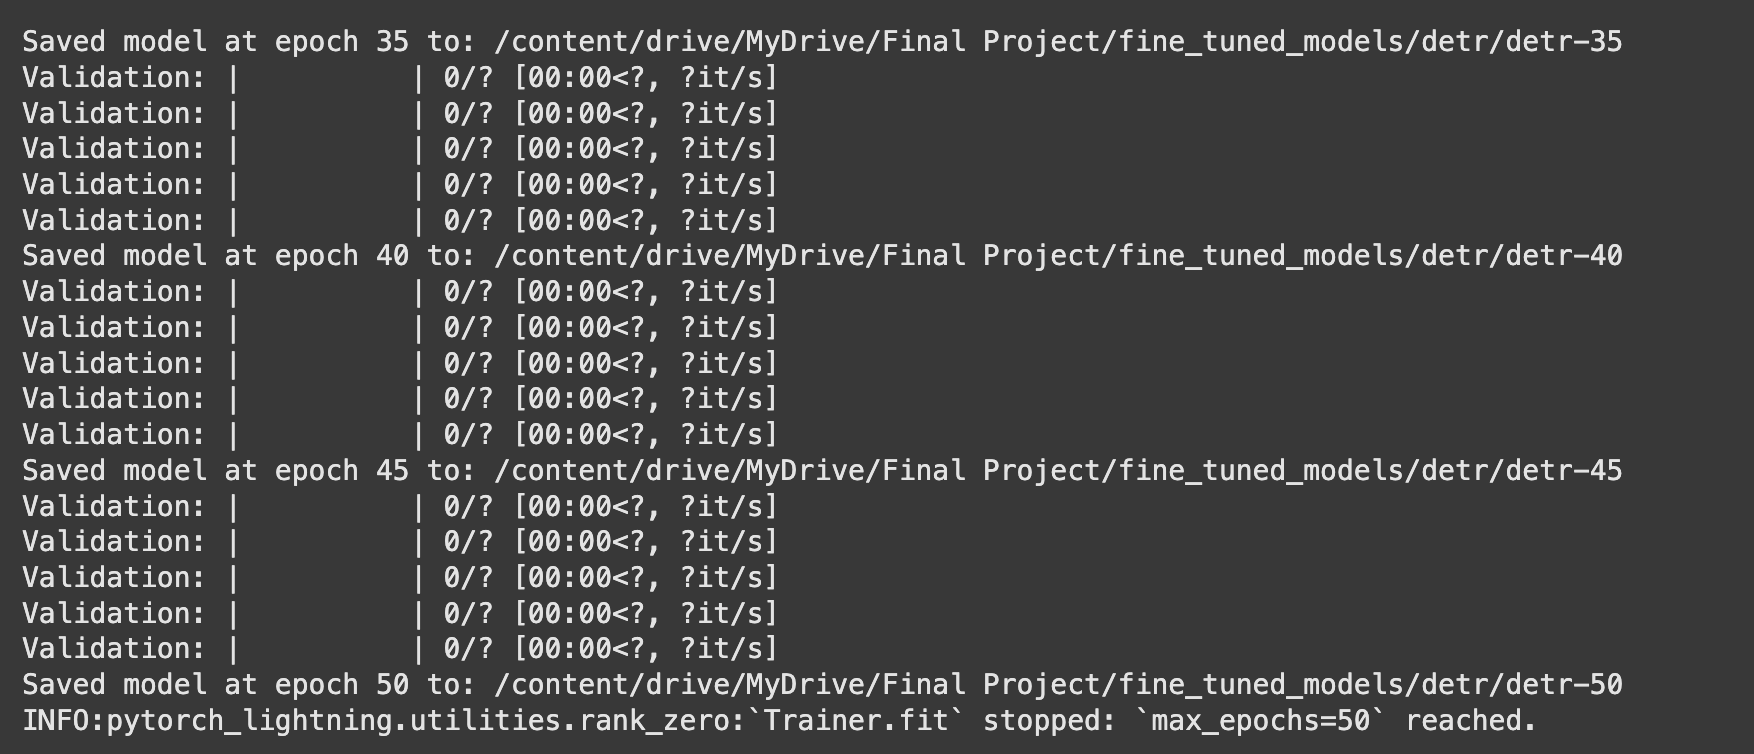

### Test the fine-tuned model

This will now test the fine-tuned model on the same image as before, and see if it can detect the tumor.

In [22]:
if torch.cuda.is_available():
    detr_device = torch.device("cuda")
elif torch.mps.is_available():
    detr_device = torch.device("mps")
else:
    detr_device = torch.device("cpu")
# Load best "100-augmented" DETR model and its processor
from transformers import DetrForObjectDetection, AutoImageProcessor
detr_model_best = DetrForObjectDetection.from_pretrained("./models/DETR/detr-augmented-100")
detr_processor_best = AutoImageProcessor.from_pretrained("./models/DETR/detr-augmented-100")

/var/folders/kd/sn90g5rn3j78k5hhy6jqx_pm0000gn/T/ipykernel_21744/1479839737.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display


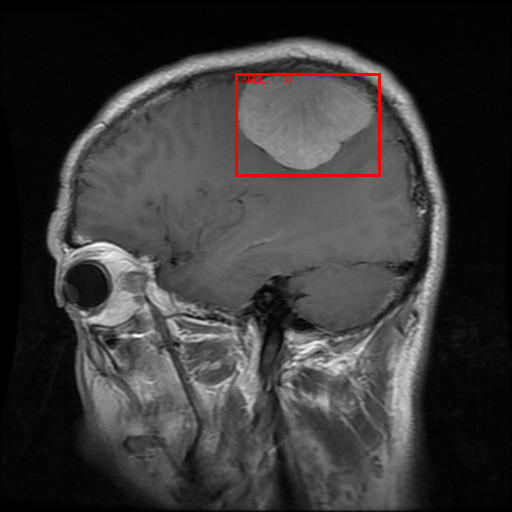

In [23]:
from PIL import Image
from IPython.core.display import display

image = Image.open("./datasets/raw/raw/meningioma/Tr-me_0547.jpg")

image_with_boxes = make_prediction(detr_model_best, detr_processor_best, image)

# Display the image with boxes
display(image_with_boxes)